In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

df = pd.read_csv('horse.csv')

names = df.columns

df['age'] = pd.Series(np.where(df.age.values == 'young', 1,0), df.index)
df['temp_of_extremities'] = pd.Series(np.where(df.temp_of_extremities.values == 'normal', 1,0), df.index)
df['surgery'] = pd.Series(np.where(df.surgery.values == 'yes', 1,0), df.index)
df['capillary_refill_time'] = pd.Series(np.where(df.capillary_refill_time.values == 
                                                'less_3_sec', 1,0), df.index)
X = df[[ 'surgery', 'age', 'total_protein', 'packed_cell_volume', 'respiratory_rate', 'pulse', 'rectal_temp', 'outcome']].copy()
X = X.dropna()
# Modify dataset

y = X[['outcome']].copy()
X = X.drop('outcome', 1)
y = pd.Series(np.where(y.outcome.values == 'lived', 1,0), y.index)
base = df['outcome'].value_counts()
# Split data using sklearn 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
base

print(X_train.describe())
print('target')
target = X_train['surgery'].value_counts()
print(target)
print(target[0] / target[1])


          surgery         age  total_protein  packed_cell_volume  \
count  152.000000  152.000000     152.000000          152.000000   
mean     0.565789    0.092105      23.992763           45.743421   
std      0.497291    0.290130      27.390754           10.280340   
min      0.000000    0.000000       3.300000           28.000000   
25%      0.000000    0.000000       6.500000           38.000000   
50%      1.000000    0.000000       7.500000           44.000000   
75%      1.000000    0.000000      55.250000           50.000000   
max      1.000000    1.000000      89.000000           75.000000   

       respiratory_rate       pulse  rectal_temp  
count        152.000000  152.000000   152.000000  
mean          30.453947   69.789474    38.205263  
std           18.425378   29.429145     0.726580  
min            9.000000   30.000000    36.000000  
25%           18.000000   48.000000    37.800000  
50%           24.000000   60.000000    38.200000  
75%           36.000000   86.5

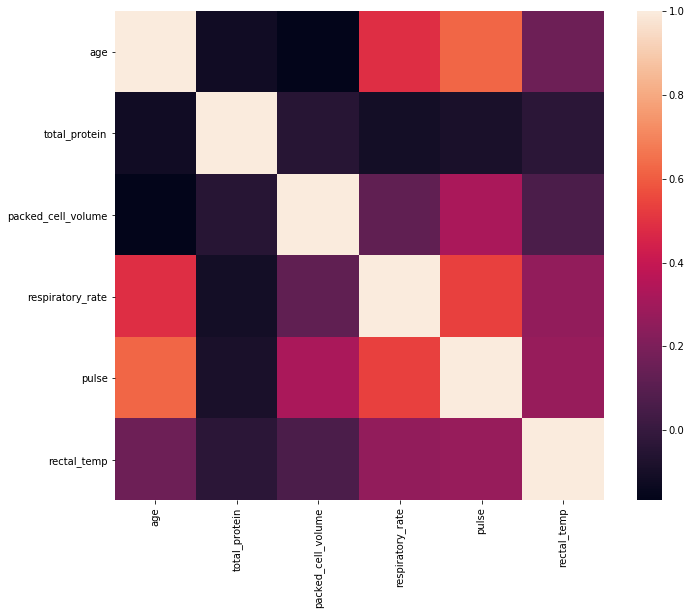

In [4]:
# Inspect correlations
df = X_train.copy()
df = df.drop(['surgery'], axis =1)
corrmat = df.corr()

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1, square=True)
plt.show()

In [18]:
# Vanilla logistic regression

# Initiate model
lr = LogisticRegression(C=1e9)

# Fit the model.
fit = lr.fit(X_train, y_train)

# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)
pred_y_sklearn = lr.predict(X_train)

print('\n Accuracy by admission status')
print(pd.crosstab(pred_y_sklearn, y_train))

print('\n Percentage accuracy')
print(lr.score(X_test, y_test))

Coefficients
[[-0.70333163  1.82795314  0.00649323 -0.07668589  0.02046101 -0.04252006
   0.36898469]]
[-7.43850895]

 Accuracy by admission status
col_0   0   1
row_0        
0      34   8
1      21  89

 Percentage accuracy
0.7894736842105263


/home/john/python3_virtualenv/python3_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [31]:
# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced. Note that by convention, the
# intercept is not regularized. Since we standardized the data
# earlier, the intercept should be equal to zero and can be dropped.
# 'total_protein', 'respiratory_rate', 'pulse', 'rectal_temp'
ridgeregr = linear_model.LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial') 
ridgeregr.fit(X_train, y_train)
print(ridgeregr.score(X_train, y_train))
#origparams = ridgeregr.coef_[0]
#print(origparams)

X2_train = X_train.copy()
X2_train['protien_pulse'] = X_train['total_protein'] * X_train['pulse']
X2_train['protien_temp'] = X_train['total_protein'] * X_train['rectal_temp']
X2_train['protien_rate'] = X_train['total_protein'] * X_train['respiratory_rate']
X2_train['pulse_sqrt'] = ( X_train['pulse'] +100) ** 2
X2_train['pulse_sqrt'] = ( X_train['pulse'] +100) ** 3

X2_test = X_test.copy()
X2_test['protien_pulse'] = X2_test['total_protein'] * X2_test['pulse']
X2_test['protien_temp'] = X2_test['total_protein'] * X2_test['rectal_temp']
X2_test['protien_rate'] = X2_test['total_protein'] * X2_test['respiratory_rate']
X2_test['pulse_sqrt'] = ( X2_test['pulse'] +100) ** 2
X2_test['pulse_sqrt'] = ( X2_test['pulse'] +100) ** 3


ridgeregrBig = linear_model.LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial') 
ridgeregrBig.fit(X2_train, y_train)
print(ridgeregrBig.score(X2_train, y_train))
#newparams = ridgeregrBig.coef_[0, 0:len(origparams)]
print(ridgeregr.score(X_test, y_test))
print(ridgeregrBig.score(X2_test, y_test))

0.7960526315789473
0.6447368421052632
0.8157894736842105
0.7894736842105263


/home/john/python3_virtualenv/python3_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [33]:
# Small number of parameters.
lass = linear_model.LogisticRegression(penalty='l1', solver='liblinear')
lassfit = lass.fit(X_train, y_train)

print(lass.score(X_test, y_test))
origparams = np.append(lassfit.coef_, lassfit.intercept_)
print('\nParameter estimates for the model with few features:')
print(origparams)

# Large number of parameters.
lassBig = linear_model.LogisticRegression(penalty='l1', solver='liblinear')
lassBig.fit(X2_train, y_train)

print(lassBig.score(X2_test, y_test))
origparams = np.append(lassBig.coef_, lassBig.intercept_)
print('\nParameter estimates for the model with many features:')
print(origparams)

0.8157894736842105

Parameter estimates for the model with few features:
[-0.54573457  0.62782113  0.00538038 -0.08554834  0.02478975 -0.03385297
  0.16631517  0.        ]
0.8157894736842105

Parameter estimates for the model with many features:
[-5.54553743e-01  7.16328336e-01 -3.04586563e-02 -8.61961961e-02
  3.21109076e-02 -5.41126156e-02  1.86108879e-01  4.40524871e-04
  3.75661886e-04 -3.22336381e-04  9.16933376e-08  0.00000000e+00]
